# **dirichlet_alpha Ablation: α=1.0,0.5,0.1**

NON-IID SEVERITY ABLATION — GA-FELCM + PVTv2-B2 (FUSION) | AUG=ON | PRE=ON | GA=ON
DEVICE: cuda | torch=2.9.0+cu128

STEP 0: DOWNLOAD DATASETS VIA kagglehub
Using Colab cache for faster access to the 'preprocessed-brain-mri-scans-for-tumors-detection' dataset.
✅ DS2 downloaded to: /kaggle/input/preprocessed-brain-mri-scans-for-tumors-detection
Using Colab cache for faster access to the 'pmram-bangladeshi-brain-cancer-mri-dataset' dataset.
✅ DS1 downloaded to: /kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset

STEP 1: LOCATE DATASET ROOTS (NO MERGE)
Dataset-1 RAW root detected:
  /kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data/Raw
Dataset-2 root detected:
  /kaggle/input/preprocessed-brain-mri-scans-for-tumors-detection/preprocessed_brain_mri_dataset
ds1_raw: 512Glioma -> glioma | 373 images
ds1_raw: 512Meningioma -> meningioma | 363 images
ds1_raw: 512Normal -> notumor | 3

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/101M [00:00<?, ?B/s]

VAL (weighted ds1+ds2): {'acc': 0.9698890649762282, 'precision_macro': 0.9529442285426394, 'recall_macro': 0.974253501587968, 'f1_macro': 0.9617358369552977, 'auc_macro_ovr': 0.9940465134601707, 'log_loss': 0.1443412500186676}
TEST DS1: {'acc': 0.9513274336283186, 'precision_macro': 0.9519654088050314, 'recall_macro': 0.9507951793968743, 'f1_macro': 0.9508225097483896, 'auc_macro_ovr': 0.9832416883813169, 'log_loss': 0.23744316606212015}
TEST DS2: {'acc': 0.9706161137440759, 'precision_macro': 0.9704429280261201, 'recall_macro': 0.9690908412122821, 'f1_macro': 0.9693717476508991, 'auc_macro_ovr': 0.9942057997541489, 'log_loss': 0.1514004581417867}
TEST GLOBAL (ds1+ds2): {'acc': 0.9672131147540983, 'precision_macro': 0.9670741378079472, 'recall_macro': 0.9657298968652193, 'f1_macro': 0.9660850699917916, 'auc_macro_ovr': 0.9920580471396778, 'log_loss': 0.16658051434006568}

RUN α = 0.5
VAL (weighted ds1+ds2): {'acc': 0.9064976228209192, 'precision_macro': 0.777605669161997, 'recall_macro

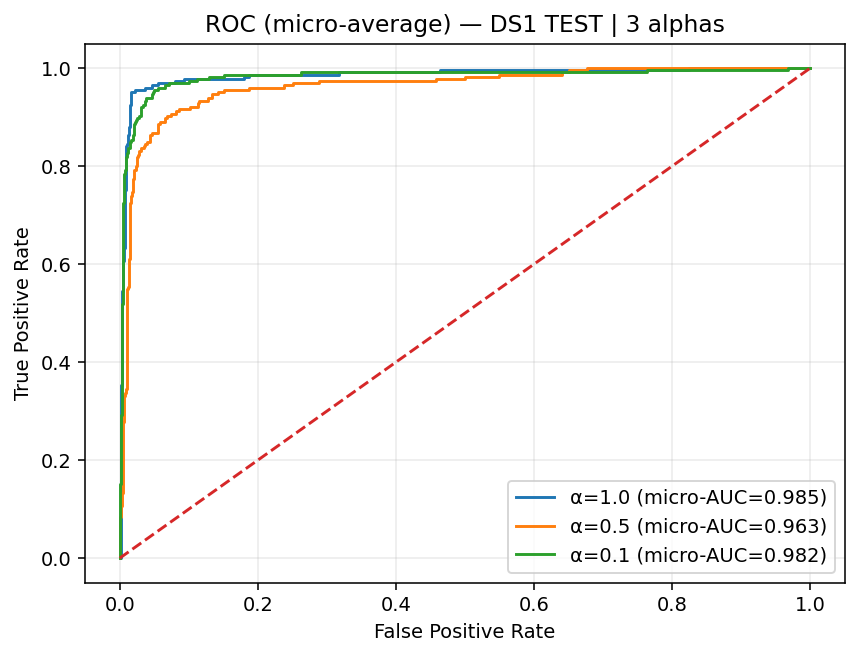

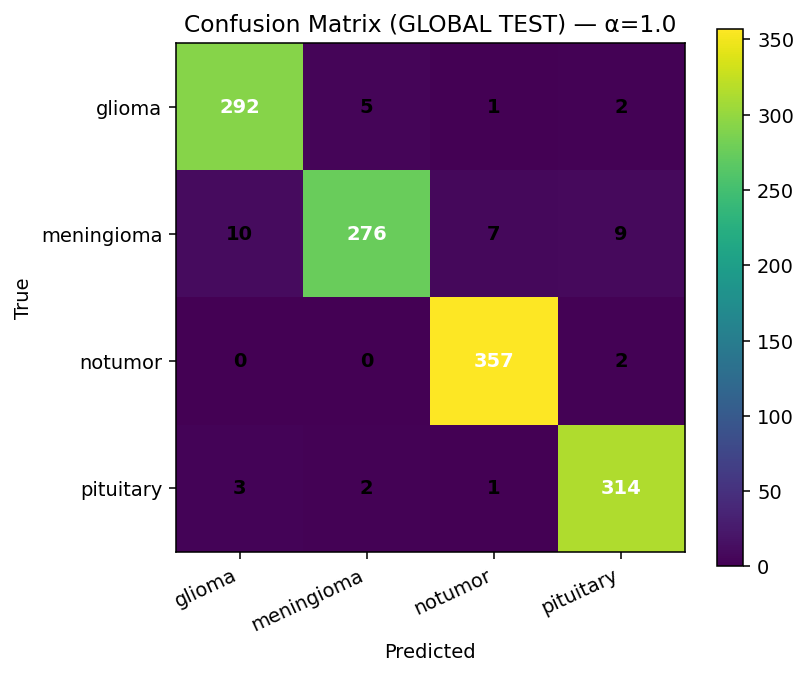

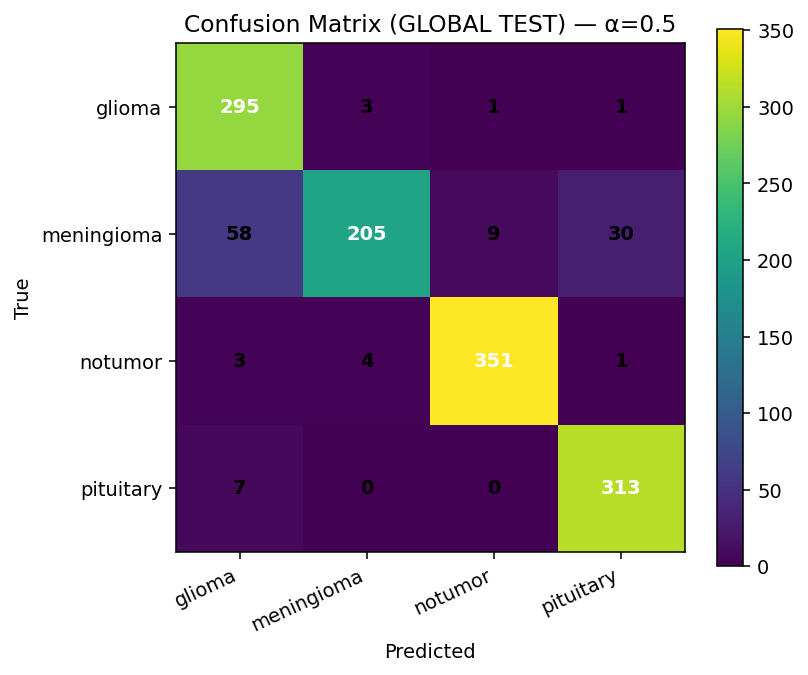

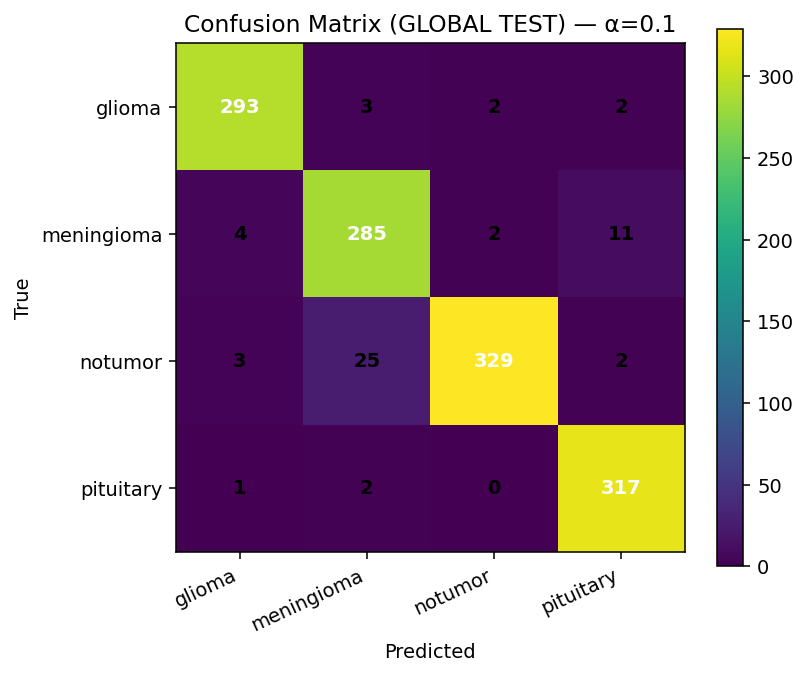

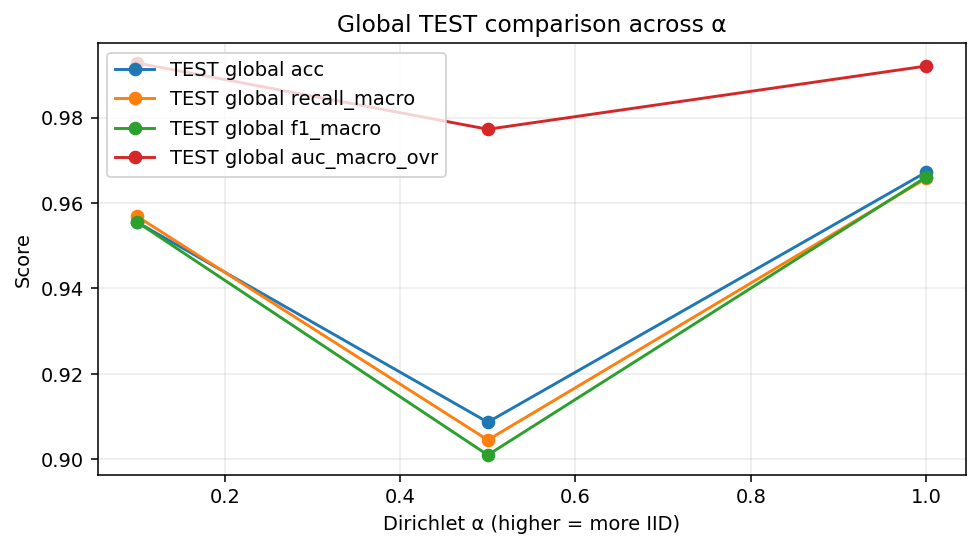


DONE ✅


In [1]:
import os, sys, time, math, random, subprocess, gc, warnings
from typing import List, Dict, Tuple

# -------------------------
# HF_TOKEN warning fix
# -------------------------
if "HF_TOKEN" not in os.environ:
    try:
        from google.colab import userdata  # type: ignore
        tok = userdata.get("HF_TOKEN")
        if tok:
            os.environ["HF_TOKEN"] = tok
    except Exception:
        pass

warnings.filterwarnings(
    "ignore",
    message=r".*The secret `HF_TOKEN` does not exist in your Colab secrets.*",
    category=UserWarning,
)

try:
    from huggingface_hub.utils import logging as hf_logging  # type: ignore
    hf_logging.set_verbosity_error()
except Exception:
    pass


def pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", pkg])


try:
    import timm
except Exception:
    pip_install("timm")
    import timm

try:
    import kagglehub
except Exception:
    pip_install("kagglehub")
    import kagglehub

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

from torchvision import transforms

SEED = 42

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    if DEVICE.type == "cuda":
        torch.backends.cuda.matmul.fp32_precision = "tf32"
        torch.backends.cudnn.conv.fp32_precision = "tf32"
except Exception:
    pass

plt.rcParams["figure.dpi"] = 140

print("=" * 92)
print("NON-IID SEVERITY ABLATION — GA-FELCM + PVTv2-B2 (FUSION) | AUG=ON | PRE=ON | GA=ON")
print("=" * 92)
print(f"DEVICE: {DEVICE} | torch={torch.__version__}")
print("=" * 92)

CFG = {
    "clients_per_dataset": 3,
    "clients_total": 6,
    "rounds": 12,
    "local_epochs": 2,
    "lr": 1e-3,
    "weight_decay": 5e-4,
    "warmup_epochs": 1,
    "label_smoothing": 0.08,
    "grad_clip": 1.0,
    "fedprox_mu": 0.01,

    "img_size": 224 if torch.cuda.is_available() else 160,
    "batch_size": 20 if torch.cuda.is_available() else 10,

    "num_workers": 0,
    "persistent_workers": False,

    "global_val_frac": 0.15,
    "test_frac": 0.15,
    "client_val_frac": 0.12,
    "client_tune_frac": 0.12,
    "min_per_class_per_client": 5,

    "use_preprocessing": True,
    "use_ga": True,
    "ga_pop": 10,
    "ga_gens": 5,
    "ga_elites": 3,
    "elite_pool_max": 18,

    "use_augmentation": True,

    "cond_dim": 128,
    "head_dropout": 0.3,

    "unfreeze_after_round": 3,
    "unfreeze_lr_mult": 0.10,
    "unfreeze_tail_frac": 0.17,
}

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(1, 3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(1, 3, 1, 1)

print("\n" + "=" * 92)
print("STEP 0: DOWNLOAD DATASETS VIA kagglehub")
print("=" * 92)

ds2_path = kagglehub.dataset_download("yassinebazgour/preprocessed-brain-mri-scans-for-tumors-detection")
print("✅ DS2 downloaded to:", ds2_path)
ds1_path = kagglehub.dataset_download("orvile/pmram-bangladeshi-brain-cancer-mri-dataset")
print("✅ DS1 downloaded to:", ds1_path)

print("\n" + "=" * 92)
print("STEP 1: LOCATE DATASET ROOTS (NO MERGE)")
print("=" * 92)

REQ1 = {"512Glioma", "512Meningioma", "512Normal", "512Pituitary"}
REQ2 = {"glioma", "meningioma", "notumor", "pituitary"}


def norm_label(name: str):
    s = str(name).strip().lower()
    if "glioma" in s:
        return "glioma"
    if "meningioma" in s:
        return "meningioma"
    if "pituitary" in s:
        return "pituitary"
    if "normal" in s or "no_tumor" in s or "no tumor" in s or "notumor" in s:
        return "notumor"
    return None


def find_root_with_required_class_dirs(base_dir, required_set, prefer_raw=True):
    candidates = []
    for root, dirs, _ in os.walk(base_dir):
        if required_set.issubset(set(dirs)):
            candidates.append(root)
    if not candidates:
        return None

    def score(p):
        pl = p.lower()
        sc = 0
        if prefer_raw:
            if "raw data" in pl:
                sc += 7
            if os.path.basename(p).lower() == "raw":
                sc += 7
            if "/raw/" in pl or "\\raw\\" in pl:
                sc += 3
            if "augmented" in pl:
                sc -= 20
        sc -= 0.0001 * len(p)
        return sc

    return max(candidates, key=score)


def list_images_under_class_root(class_root, class_dir_name):
    class_dir = os.path.join(class_root, class_dir_name)
    out = []
    for r, _, files in os.walk(class_dir):
        for fn in files:
            if fn.lower().endswith(IMG_EXTS):
                out.append(os.path.join(r, fn))
    return out


def build_df_from_root(ds_root, class_dirs, source_name):
    rows = []
    for c in class_dirs:
        lab = norm_label(c)
        imgs = list_images_under_class_root(ds_root, c)
        print(f"{source_name}: {c} -> {lab} | {len(imgs)} images")
        for p in imgs:
            rows.append({"path": p, "label": lab, "source": source_name})
    dfm = pd.DataFrame(rows).dropna().reset_index(drop=True)
    dfm["path"] = dfm["path"].astype(str)
    dfm["label"] = dfm["label"].astype(str)
    dfm["source"] = dfm["source"].astype(str)
    dfm = dfm.drop_duplicates(subset=["path"]).reset_index(drop=True)
    return dfm


DS1_ROOT = find_root_with_required_class_dirs(ds1_path, REQ1, prefer_raw=True)
if DS1_ROOT is None:
    raise RuntimeError("Could not locate DS1 RAW root.")
print("Dataset-1 RAW root detected:\n ", DS1_ROOT)

DS2_ROOT = find_root_with_required_class_dirs(ds2_path, REQ2, prefer_raw=False)
if DS2_ROOT is None:
    raise RuntimeError("Could not locate DS2 root.")
print("Dataset-2 root detected:\n ", DS2_ROOT)

df1 = build_df_from_root(DS1_ROOT, ["512Glioma", "512Meningioma", "512Normal", "512Pituitary"], "ds1_raw")
df2 = build_df_from_root(DS2_ROOT, ["glioma", "meningioma", "notumor", "pituitary"], "ds2")

labels = ["glioma", "meningioma", "notumor", "pituitary"]
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}
NUM_CLASSES = len(labels)


def enforce_labels(df_):
    df_ = df_.copy()
    df_["label"] = df_["label"].astype(str).str.strip().str.lower()
    df_ = df_[df_["label"].isin(set(labels))].reset_index(drop=True)
    df_["y"] = df_["label"].map(label2id).astype(int)
    return df_


df1 = enforce_labels(df1)
df2 = enforce_labels(df2)

print(f"\nDS1 images: {len(df1)} | DS2 images: {len(df2)}")

print("\n" + "=" * 92)
print("STEP 2: TRAIN/VAL/TEST SPLIT (PER DATASET) — FIXED FOR ALL α")
print("=" * 92)


def split_dataset(df_):
    train_df, temp_df = train_test_split(
        df_,
        test_size=(CFG["global_val_frac"] + CFG["test_frac"]),
        stratify=df_["y"],
        random_state=SEED,
    )
    val_rel = CFG["global_val_frac"] / (CFG["global_val_frac"] + CFG["test_frac"])
    val_df, test_df = train_test_split(
        temp_df,
        test_size=(1 - val_rel),
        stratify=temp_df["y"],
        random_state=SEED,
    )
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)


train1, val1, test1 = split_dataset(df1)
train2, val2, test2 = split_dataset(df2)

print(f"DS1 TRAIN: {len(train1)} | VAL: {len(val1)} | TEST: {len(test1)}")
print(f"DS2 TRAIN: {len(train2)} | VAL: {len(val2)} | TEST: {len(test2)}")


def load_rgb(path):
    try:
        return Image.open(path).convert("RGB")
    except Exception:
        return Image.new("RGB", (CFG["img_size"], CFG["img_size"]), (128, 128, 128))


EVAL_TFMS = transforms.Compose([
    transforms.Resize((CFG["img_size"], CFG["img_size"])),
    transforms.ToTensor(),
])

if CFG["use_augmentation"]:
    TRAIN_TFMS = transforms.Compose([
        transforms.Resize((CFG["img_size"], CFG["img_size"])),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
    ])
else:
    TRAIN_TFMS = EVAL_TFMS


class MRIDataset(Dataset):
    def __init__(self, frame, indices=None, tfms=None, source_id=0, client_id=0):
        self.df = frame
        self.indices = indices if indices is not None else list(range(len(frame)))
        self.tfms = tfms
        self.source_id = int(source_id)
        self.client_id = int(client_id)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        j = self.indices[i]
        row = self.df.iloc[j]
        img = load_rgb(row["path"])
        x = self.tfms(img) if self.tfms is not None else transforms.ToTensor()(img)
        y = int(row["y"])
        return x, y, self.source_id, self.client_id


def make_weighted_sampler(frame, indices, num_classes):
    if len(indices) == 0:
        return None
    ys = frame.loc[indices, "y"].values
    class_counts = np.bincount(ys, minlength=num_classes)
    class_weights = 1.0 / np.clip(class_counts, 1, None)
    sample_weights = class_weights[ys]
    return WeightedRandomSampler(
        weights=torch.DoubleTensor(sample_weights),
        num_samples=len(sample_weights),
        replacement=True,
    )


def make_loader(frame, indices, bs, tfms, shuffle=False, sampler=None, source_id=0, client_id=0):
    ds = MRIDataset(frame, indices=indices, tfms=tfms, source_id=source_id, client_id=client_id)
    return DataLoader(
        ds,
        batch_size=bs,
        shuffle=(shuffle and sampler is None),
        sampler=sampler,
        num_workers=CFG["num_workers"],
        pin_memory=(DEVICE.type == "cuda"),
        drop_last=False,
        persistent_workers=CFG["persistent_workers"],
    )


def _n_test_from_frac(n, frac):
    nt = int(round(n * float(frac)))
    nt = max(1, nt)
    nt = min(n - 1, nt)
    return nt


def safe_split_indices(idxs, y, test_size_frac, seed=42):
    idxs = np.array(idxs, dtype=int)
    n = len(idxs)
    if n < 2:
        return idxs, idxs[:0]

    y = np.array(y)
    n_test = _n_test_from_frac(n, test_size_frac)

    classes, counts = np.unique(y, return_counts=True)
    n_classes = len(classes)

    can_stratify = (
        n_classes >= 2 and
        n_test >= n_classes and
        (n - n_test) >= n_classes and
        counts.min() >= 2
    )

    if can_stratify:
        try:
            tr, te = train_test_split(
                idxs,
                test_size=n_test,
                stratify=y,
                random_state=seed
            )
            return np.array(tr, dtype=int), np.array(te, dtype=int)
        except Exception:
            pass

    rng = np.random.RandomState(seed)
    perm = rng.permutation(idxs)
    te = perm[:n_test]
    tr = perm[n_test:]
    return np.array(tr, dtype=int), np.array(te, dtype=int)


def robust_client_splits(train_df, indices, val_frac, tune_frac):
    idxs = np.array(indices, dtype=int)
    if len(idxs) < 3:
        return idxs.tolist(), idxs.tolist(), idxs.tolist()

    y_all = train_df.loc[idxs, "y"].values
    rem_idx, tune_idx = safe_split_indices(idxs, y_all, tune_frac, seed=SEED)

    if len(rem_idx) < 2:
        return rem_idx.tolist(), tune_idx.tolist(), rem_idx.tolist()

    y_rem = train_df.loc[rem_idx, "y"].values
    train_idx, val_idx = safe_split_indices(rem_idx, y_rem, val_frac, seed=SEED)

    if len(train_idx) == 0:
        train_idx = val_idx.copy()
    if len(val_idx) == 0:
        val_idx = train_idx[:1].copy()

    return train_idx.tolist(), tune_idx.tolist(), val_idx.tolist()


class EnhancedFELCM(nn.Module):
    def __init__(self, gamma=1.0, alpha=0.35, beta=6.0, tau=2.5, blur_k=7, sharpen=0.0, denoise=0.0):
        super().__init__()
        self.gamma = float(gamma)
        self.alpha = float(alpha)
        self.beta = float(beta)
        self.tau = float(tau)
        self.blur_k = int(blur_k)
        self.sharpen = float(sharpen)
        self.denoise = float(denoise)

        lap = torch.tensor([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=torch.float32)
        self.register_buffer("lap", lap.view(1, 1, 3, 3))

        sharp = torch.tensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=torch.float32)
        self.register_buffer("sharp_kernel", sharp.view(1, 1, 3, 3))

    def forward(self, x):
        eps = 1e-6
        B, C, H, W = x.shape

        if self.denoise > 0:
            k = 3
            x_blur = F.avg_pool2d(F.pad(x, (1, 1, 1, 1), mode="reflect"), k, 1)
            x = x * (1 - self.denoise) + x_blur * self.denoise

        mu = x.mean(dim=(2, 3), keepdim=True)
        sd = x.std(dim=(2, 3), keepdim=True).clamp_min(eps)
        x0 = (x - mu) / sd
        x0 = x0.clamp(-self.tau, self.tau)

        x1 = torch.sign(x0) * torch.pow(torch.abs(x0).clamp_min(eps), self.gamma)

        gray = x1.mean(dim=1, keepdim=True)
        lap = F.conv2d(F.pad(gray, (1, 1, 1, 1), mode="reflect"), self.lap)
        mag = lap.abs()

        k = self.blur_k if self.blur_k % 2 == 1 else self.blur_k + 1
        pad = k // 2
        blur = F.avg_pool2d(F.pad(mag, (pad, pad, pad, pad), mode="reflect"), k, 1)
        C_map = mag / (blur + eps)

        x2 = x1 + self.alpha * torch.tanh(self.beta * C_map)

        if self.sharpen > 0:
            outs = []
            for c in range(C):
                x_c = x2[:, c: c + 1, :, :]
                x_sharp = F.conv2d(F.pad(x_c, (1, 1, 1, 1), mode="reflect"), self.sharp_kernel)
                outs.append(x_c * (1 - self.sharpen) + x_sharp * self.sharpen)
            x2 = torch.cat(outs, dim=1)

        mn = x2.amin(dim=(2, 3), keepdim=True)
        mx = x2.amax(dim=(2, 3), keepdim=True)
        x3 = (x2 - mn) / (mx - mn + eps)
        return x3.clamp(0, 1)


def theta_to_module(theta):
    return EnhancedFELCM(*theta)


def random_theta():
    gamma = random.uniform(0.7, 1.4)
    alpha = random.uniform(0.15, 0.55)
    beta = random.uniform(3.0, 9.0)
    tau = random.uniform(1.8, 3.2)
    blur_k = random.choice([3, 5, 7])
    sharpen = random.uniform(0.0, 0.25)
    denoise = random.uniform(0.0, 0.2)
    return (gamma, alpha, beta, tau, blur_k, sharpen, denoise)


def mutate(theta, p=0.8):
    if random.random() > p:
        return theta
    g, a, b, t, k, sh, dn = theta
    g = float(np.clip(g + np.random.normal(0, 0.06), 0.6, 1.5))
    a = float(np.clip(a + np.random.normal(0, 0.05), 0.08, 0.7))
    b = float(np.clip(b + np.random.normal(0, 0.5), 2.0, 11.0))
    t = float(np.clip(t + np.random.normal(0, 0.2), 1.5, 3.8))
    if random.random() < 0.3:
        k = random.choice([3, 5, 7])
    sh = float(np.clip(sh + np.random.normal(0, 0.04), 0.0, 0.35))
    dn = float(np.clip(dn + np.random.normal(0, 0.03), 0.0, 0.3))
    return (g, a, b, t, int(k), sh, dn)


def crossover(t1, t2):
    return tuple(random.choice([a, b]) for a, b in zip(t1, t2))


IDENTITY_PRE = nn.Identity().to(DEVICE)

BACKBONE_NAME = "pvt_v2_b2"


class TokenAttentionPooling(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, 1)

    def forward(self, x):
        attn = torch.softmax(self.query(x).squeeze(-1), dim=1)
        return (x * attn.unsqueeze(-1)).sum(dim=1)


class MultiScaleFeatureFuser(nn.Module):
    def __init__(self, in_channels: List[int], out_dim: int):
        super().__init__()
        self.proj = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(c, out_dim, kernel_size=1, bias=False),
                nn.GroupNorm(8, out_dim),
                nn.GELU(),
            ) for c in in_channels
        ])
        self.fuse = nn.Sequential(
            nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(8, out_dim),
            nn.GELU(),
        )
        self.pool = TokenAttentionPooling(out_dim)

    def forward(self, feats):
        proj_feats = [p(f) for p, f in zip(self.proj, feats)]
        x = proj_feats[-1]
        for f in reversed(proj_feats[:-1]):
            x = F.interpolate(x, size=f.shape[-2:], mode="bilinear", align_corners=False)
            x = x + f
        x = self.fuse(x)
        tokens = x.flatten(2).transpose(1, 2)
        return self.pool(tokens)


class EnhancedBrainTuner(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.se = nn.Sequential(
            nn.Linear(dim, max(8, dim // 4)),
            nn.ReLU(inplace=True),
            nn.Linear(max(8, dim // 4), dim),
            nn.Sigmoid(),
        )
        self.refine = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
        )
        self.gate = nn.Parameter(torch.ones(2) / 2)

    def forward(self, x):
        gate = F.softmax(self.gate, dim=0)
        out1 = x * self.se(x)
        out2 = x + 0.2 * self.refine(x)
        return gate[0] * out1 + gate[1] * out2


class PVTv2B2_MultiScale(nn.Module):
    def __init__(self, num_classes, pretrained=True, head_dropout=0.3, cond_dim=128, num_clients=6):
        super().__init__()
        self.backbone = timm.create_model(
            BACKBONE_NAME, pretrained=pretrained, features_only=True, out_indices=(0, 1, 2, 3),
        )
        in_channels = self.backbone.feature_info.channels()
        out_dim = max(256, in_channels[-1] // 2)

        self.fuser = MultiScaleFeatureFuser(in_channels, out_dim)
        self.tuner = EnhancedBrainTuner(out_dim, dropout=0.1)

        self.classifier = nn.Sequential(
            nn.LayerNorm(out_dim),
            nn.Dropout(head_dropout),
            nn.Linear(out_dim, max(64, out_dim // 2)),
            nn.GELU(),
            nn.Dropout(head_dropout * 0.5),
            nn.Linear(max(64, out_dim // 2), num_classes),
        )

        self.theta_mlp = nn.Sequential(
            nn.Linear(7, cond_dim),
            nn.GELU(),
            nn.Linear(cond_dim, cond_dim),
        )
        self.source_emb = nn.Embedding(2, cond_dim)
        self.client_emb = nn.Embedding(num_clients, cond_dim)
        self.cond_norm = nn.LayerNorm(cond_dim)

        self.gate_early = nn.Linear(cond_dim, 3)
        self.gate_mid = nn.Linear(cond_dim, out_dim)
        self.gate_late = nn.Linear(cond_dim, out_dim)

    def _cond_vec(self, theta_vec, source_id, client_id):
        cond = self.theta_mlp(theta_vec)
        cond = cond + self.source_emb(source_id) + self.client_emb(client_id)
        return self.cond_norm(cond)

    def forward(self, x_raw_n, x_fel_n, theta_vec, source_id, client_id):
        cond = self._cond_vec(theta_vec, source_id, client_id)

        g0 = torch.sigmoid(self.gate_early(cond)).view(-1, 3, 1, 1)
        x0 = (1 - g0) * x_raw_n + g0 * x_fel_n

        feats0 = self.backbone(x0)
        feats1 = self.backbone(x_fel_n)

        f0 = self.fuser(feats0)
        f1 = self.fuser(feats1)

        g1 = torch.sigmoid(self.gate_mid(cond))
        f_mid = (1 - g1) * f0 + g1 * f1

        t0 = self.tuner(f0)
        t1 = self.tuner(f1)
        t_mid = self.tuner(f_mid)

        t_views = 0.5 * (t0 + t1)
        g2 = torch.sigmoid(self.gate_late(cond))
        t_final = (1 - g2) * t_mid + g2 * t_views

        return self.classifier(t_final)


def set_trainable_for_round(model, rnd):
    for p in model.backbone.parameters():
        p.requires_grad = False
    for n, p in model.named_parameters():
        if not n.startswith("backbone."):
            p.requires_grad = True
    if rnd >= CFG["unfreeze_after_round"]:
        params = list(model.backbone.parameters())
        tail_n = max(1, int(len(params) * CFG["unfreeze_tail_frac"]))
        for p in params[-tail_n:]:
            p.requires_grad = True


def make_optimizer(model):
    head_params, bb_params = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        (bb_params if n.startswith("backbone.") else head_params).append(p)
    groups = []
    if head_params:
        groups.append({"params": head_params, "lr": CFG["lr"]})
    if bb_params:
        groups.append({"params": bb_params, "lr": CFG["lr"] * CFG["unfreeze_lr_mult"]})
    return torch.optim.AdamW(groups, weight_decay=CFG["weight_decay"])


@torch.no_grad()
def enhanced_separability_score(emb, y):
    eps = 1e-6
    y = y.long()
    classes = torch.unique(y)
    if len(classes) < 2:
        return 0.0
    centroids, within_vars, sizes = [], [], []
    for c in classes:
        mask = y == c
        e = emb[mask]
        if e.size(0) < 2:
            continue
        mu = e.mean(dim=0)
        var = (e - mu).pow(2).sum(dim=1).mean().item()
        centroids.append(mu)
        within_vars.append(var)
        sizes.append(e.size(0))
    if len(centroids) < 2:
        return 0.0
    centroids = torch.stack(centroids, dim=0)
    global_mean = centroids.mean(dim=0)
    between = sum(n * (c - global_mean).pow(2).sum().item() for c, n in zip(centroids, sizes))
    within = float(np.mean(within_vars)) if within_vars else eps
    return float(between / (within + eps))


@torch.no_grad()
def ga_fitness(theta, backbone_frozen, batch_x, batch_y):
    pre = theta_to_module(theta).to(DEVICE)
    x = batch_x.to(DEVICE)
    y = batch_y.to(DEVICE)

    x_p = pre(x)
    gray = x_p.mean(dim=1, keepdim=True)
    lap = F.conv2d(F.pad(gray, (1, 1, 1, 1), mode="reflect"), pre.lap).abs()
    contrast = float(lap.mean().item())
    dyn_range = float((x_p.max() - x_p.min()).item())

    x_n = (x_p - IMAGENET_MEAN) / IMAGENET_STD
    emb = backbone_frozen(x_n)
    if isinstance(emb, (list, tuple)):
        emb = emb[-1].mean(dim=(2, 3))
    sep = enhanced_separability_score(emb, y)

    g, a, b, t, k, sh, dn = theta
    cost = (0.03 * abs(g - 1.0) + 0.05 * a + 0.01 * (b / 10.0) +
            0.02 * abs(t - 2.5) + 0.02 * sh + 0.02 * dn)

    return 0.35 * contrast + 0.15 * dyn_range + 1.35 * sep - 0.5 * cost


def _safe_first_batch(dl):
    it = iter(dl)
    bx, by, *_ = next(it)
    return bx, by


def run_ga_for_client(backbone_frozen, dl_for_eval, elite_pool):
    bx, by = _safe_first_batch(dl_for_eval)
    bx = bx[: CFG["batch_size"]].contiguous()
    by = by[: CFG["batch_size"]].contiguous()

    pop = []
    if elite_pool:
        pop.extend(elite_pool[: min(len(elite_pool), CFG["ga_pop"] // 2)])
    while len(pop) < CFG["ga_pop"]:
        pop.append(random_theta())

    for _ in range(CFG["ga_gens"]):
        scored = [(ga_fitness(th, backbone_frozen, bx, by), th) for th in pop]
        scored.sort(key=lambda x: x[0], reverse=True)
        elites = [th for _, th in scored[: CFG["ga_elites"]]]

        new_pop = elites[:]
        while len(new_pop) < CFG["ga_pop"]:
            p1, p2 = random.sample(elites + pop[: max(2, CFG["ga_pop"] // 2)], 2)
            child = mutate(crossover(p1, p2), p=0.75)
            new_pop.append(child)
        pop = new_pop

    scored = [(ga_fitness(th, backbone_frozen, bx, by), th) for th in pop]
    scored.sort(key=lambda x: x[0], reverse=True)
    best_theta = scored[0][1]
    top = [th for _, th in scored[: CFG["ga_elites"]]]
    return best_theta, top


def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(step):
        if step < num_warmup_steps:
            return float(step) / float(max(1, num_warmup_steps))
        progress = float(step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def preproc_theta_vec(preproc_module, batch_size):
    if hasattr(preproc_module, "gamma"):
        theta = torch.tensor(
            [
                preproc_module.gamma,
                preproc_module.alpha,
                preproc_module.beta,
                preproc_module.tau,
                float(preproc_module.blur_k) / 7.0,
                preproc_module.sharpen,
                preproc_module.denoise,
            ],
            device=DEVICE, dtype=torch.float32,
        )
    else:
        theta = torch.zeros(7, device=DEVICE, dtype=torch.float32)
    return theta.unsqueeze(0).repeat(batch_size, 1)


@torch.no_grad()
def evaluate_full(model, loader, preproc_module):
    model.eval()
    preproc_module.eval()

    all_y, all_p = [], []
    for x, y, source_id, client_id in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        source_id = source_id.to(DEVICE, non_blocking=True)
        client_id = client_id.to(DEVICE, non_blocking=True)

        x_p = preproc_module(x)
        x_raw_n = (x - IMAGENET_MEAN) / IMAGENET_STD
        x_fel_n = (x_p - IMAGENET_MEAN) / IMAGENET_STD

        theta_vec = preproc_theta_vec(preproc_module, x.size(0))
        logits = model(x_raw_n, x_fel_n, theta_vec, source_id, client_id)

        probs = torch.softmax(logits, dim=1)
        all_y.append(y.detach().cpu().numpy())
        all_p.append(probs.detach().cpu().numpy())

    y_true = np.concatenate(all_y) if all_y else np.array([])
    p_pred = np.concatenate(all_p) if all_p else np.array([])
    if len(y_true) == 0:
        empty = {
            "acc": np.nan,
            "precision_macro": np.nan,
            "recall_macro": np.nan,
            "f1_macro": np.nan,
            "auc_macro_ovr": np.nan,
            "log_loss": np.nan,
        }
        return empty, y_true, p_pred

    y_hat = np.argmax(p_pred, axis=1)

    met = {
        "acc": float(accuracy_score(y_true, y_hat)),
        "precision_macro": float(precision_score(y_true, y_hat, average="macro", zero_division=0)),
        "recall_macro": float(recall_score(y_true, y_hat, average="macro", zero_division=0)),
        "f1_macro": float(f1_score(y_true, y_hat, average="macro", zero_division=0)),
        "log_loss": float(log_loss(y_true, p_pred, labels=list(range(NUM_CLASSES)))),
    }
    try:
        met["auc_macro_ovr"] = float(roc_auc_score(y_true, p_pred, multi_class="ovr", average="macro"))
    except Exception:
        met["auc_macro_ovr"] = np.nan

    return met, y_true, p_pred


def fedprox_term(local_model, global_model):
    loss = 0.0
    for p_local, p_global in zip(local_model.parameters(), global_model.parameters()):
        loss += ((p_local - p_global.detach()) ** 2).sum()
    return loss


def train_one_epoch(model, loader, optimizer, preproc_module, criterion, global_model=None, scheduler=None, scaler=None):
    model.train()
    preproc_module.eval()

    for x, y, source_id, client_id in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        source_id = source_id.to(DEVICE, non_blocking=True)
        client_id = client_id.to(DEVICE, non_blocking=True)

        with torch.amp.autocast(device_type=DEVICE.type, enabled=(scaler is not None)):
            x_p = preproc_module(x)
            x_raw_n = (x - IMAGENET_MEAN) / IMAGENET_STD
            x_fel_n = (x_p - IMAGENET_MEAN) / IMAGENET_STD
            theta_vec = preproc_theta_vec(preproc_module, x.size(0))
            logits = model(x_raw_n, x_fel_n, theta_vec, source_id, client_id)
            loss = criterion(logits, y)
            if global_model is not None and CFG["fedprox_mu"] > 0:
                loss = loss + 0.5 * CFG["fedprox_mu"] * fedprox_term(model, global_model)

        optimizer.zero_grad(set_to_none=True)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CFG["grad_clip"])
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CFG["grad_clip"])
            optimizer.step()

        if scheduler is not None:
            scheduler.step()


def fedavg_update(global_model, local_models, weights, trainable_names):
    gsd = global_model.state_dict()
    new_sd = {}
    for name in trainable_names:
        acc = None
        for m, w in zip(local_models, weights):
            p = m.state_dict()[name].detach().float().cpu()
            acc = (w * p) if acc is None else (acc + w * p)
        new_sd[name] = acc
    for name, t in new_sd.items():
        gsd[name].copy_(t.to(gsd[name].device).type_as(gsd[name]))
    global_model.load_state_dict(gsd)


def make_clients_non_iid(train_df, n_clients, num_classes, min_per_class=5, alpha=0.35):
    y = train_df["y"].values
    idx_by_class = {c: np.where(y == c)[0].tolist() for c in range(num_classes)}
    for c in idx_by_class:
        random.shuffle(idx_by_class[c])

    client_indices = [[] for _ in range(n_clients)]

    for c in range(num_classes):
        idxs = idx_by_class[c]
        feasible = min(min_per_class, max(1, len(idxs) // n_clients))
        for k in range(n_clients):
            take = idxs[:feasible]
            idxs = idxs[feasible:]
            client_indices[k].extend(take)
        idx_by_class[c] = idxs

    for c in range(num_classes):
        idxs = idx_by_class[c]
        if len(idxs) == 0:
            continue
        props = np.random.dirichlet([alpha] * n_clients)
        counts = (props * len(idxs)).astype(int)
        diff = len(idxs) - counts.sum()
        counts[np.argmax(props)] += diff

        start = 0
        for k in range(n_clients):
            client_indices[k].extend(idxs[start: start + counts[k]])
            start += counts[k]

    for k in range(n_clients):
        random.shuffle(client_indices[k])
    return client_indices


def weighted_aggregate(metrics_with_sizes: List[Tuple[Dict, int]]) -> Dict:
    if not metrics_with_sizes:
        return {}
    total = sum(sz for _, sz in metrics_with_sizes)
    if total <= 0:
        return {}
    keys = metrics_with_sizes[0][0].keys()
    out = {}
    for k in keys:
        vals, ws = [], []
        for met, sz in metrics_with_sizes:
            vals.append(met.get(k, np.nan))
            ws.append(sz)
        out[k] = float(np.average(vals, weights=ws))
    return out


def compute_metrics(y_true, p_pred):
    y_true = np.array(y_true)
    p_pred = np.array(p_pred)
    if y_true.size == 0:
        return {
            "acc": np.nan,
            "precision_macro": np.nan,
            "recall_macro": np.nan,
            "f1_macro": np.nan,
            "auc_macro_ovr": np.nan,
            "log_loss": np.nan,
        }

    y_hat = np.argmax(p_pred, axis=1)
    out = {
        "acc": float(accuracy_score(y_true, y_hat)),
        "precision_macro": float(precision_score(y_true, y_hat, average="macro", zero_division=0)),
        "recall_macro": float(recall_score(y_true, y_hat, average="macro", zero_division=0)),
        "f1_macro": float(f1_score(y_true, y_hat, average="macro", zero_division=0)),
        "log_loss": float(log_loss(y_true, p_pred, labels=list(range(NUM_CLASSES)))),
    }
    try:
        out["auc_macro_ovr"] = float(roc_auc_score(y_true, p_pred, multi_class="ovr", average="macro"))
    except Exception:
        out["auc_macro_ovr"] = np.nan
    return out


def run_one_alpha(dir_alpha: float):
    seed_everything(SEED)

    n_per_ds = CFG["clients_per_dataset"]
    n_total = CFG["clients_total"]

    client_indices_ds1 = make_clients_non_iid(
        train1, n_clients=n_per_ds, num_classes=NUM_CLASSES,
        min_per_class=CFG["min_per_class_per_client"], alpha=dir_alpha
    )
    client_indices_ds2 = make_clients_non_iid(
        train2, n_clients=n_per_ds, num_classes=NUM_CLASSES,
        min_per_class=CFG["min_per_class_per_client"], alpha=dir_alpha
    )

    client_loaders = []

    for k in range(n_per_ds):
        tr, tune, va = robust_client_splits(train1, client_indices_ds1[k], CFG["client_val_frac"], CFG["client_tune_frac"])
        gid = k
        sampler = make_weighted_sampler(train1, tr, NUM_CLASSES)
        tr_loader = make_loader(train1, tr, CFG["batch_size"], TRAIN_TFMS, shuffle=(sampler is None), sampler=sampler, source_id=0, client_id=gid)
        tune_loader = make_loader(train1, tune if len(tune) else tr[:max(1, len(tr))], CFG["batch_size"], EVAL_TFMS, shuffle=True, source_id=0, client_id=gid)
        val_loader = make_loader(train1, va if len(va) else tr[:max(1, min(len(tr), CFG["batch_size"]))], CFG["batch_size"], EVAL_TFMS, shuffle=False, source_id=0, client_id=gid)
        client_loaders.append((tr_loader, tune_loader, val_loader))

    for k in range(n_per_ds):
        tr, tune, va = robust_client_splits(train2, client_indices_ds2[k], CFG["client_val_frac"], CFG["client_tune_frac"])
        gid = n_per_ds + k
        sampler = make_weighted_sampler(train2, tr, NUM_CLASSES)
        tr_loader = make_loader(train2, tr, CFG["batch_size"], TRAIN_TFMS, shuffle=(sampler is None), sampler=sampler, source_id=1, client_id=gid)
        tune_loader = make_loader(train2, tune if len(tune) else tr[:max(1, len(tr))], CFG["batch_size"], EVAL_TFMS, shuffle=True, source_id=1, client_id=gid)
        val_loader = make_loader(train2, va if len(va) else tr[:max(1, min(len(tr), CFG["batch_size"]))], CFG["batch_size"], EVAL_TFMS, shuffle=False, source_id=1, client_id=gid)
        client_loaders.append((tr_loader, tune_loader, val_loader))

    ds1_test_loader = make_loader(test1, list(range(len(test1))), CFG["batch_size"], EVAL_TFMS, shuffle=False, source_id=0, client_id=0)
    ds2_test_loader = make_loader(test2, list(range(len(test2))), CFG["batch_size"], EVAL_TFMS, shuffle=False, source_id=1, client_id=n_per_ds)

    global_model = PVTv2B2_MultiScale(
        num_classes=NUM_CLASSES, pretrained=True,
        head_dropout=CFG["head_dropout"], cond_dim=CFG["cond_dim"], num_clients=n_total
    ).to(DEVICE)
    set_trainable_for_round(global_model, rnd=1)

    backbone_frozen = global_model.backbone.eval()
    for p in backbone_frozen.parameters():
        p.requires_grad = False

    counts1 = train1["y"].value_counts().sort_index().reindex(range(NUM_CLASSES), fill_value=0).values
    counts2 = train2["y"].value_counts().sort_index().reindex(range(NUM_CLASSES), fill_value=0).values
    counts = counts1 + counts2
    w = (counts.sum() / np.clip(counts, 1, None)).astype(np.float32)
    w = w / max(1e-6, w.mean())
    class_w = torch.tensor(w, device=DEVICE)

    criterion = nn.CrossEntropyLoss(weight=class_w, label_smoothing=CFG["label_smoothing"])
    scaler = torch.amp.GradScaler("cuda") if DEVICE.type == "cuda" else None

    elite_pool_ds1, elite_pool_ds2 = [], []

    best_val_acc = -1.0
    best_state = None
    best_theta_ds1 = None
    best_theta_ds2 = None

    for rnd in range(1, CFG["rounds"] + 1):
        local_models = []
        local_weights = []
        val_mets = []

        for k in range(n_total):
            tr_loader, tune_loader, val_loader = client_loaders[k]
            ds_name = "ds1" if k < n_per_ds else "ds2"
            elite_pool = elite_pool_ds1 if ds_name == "ds1" else elite_pool_ds2

            if CFG["use_preprocessing"] and CFG["use_ga"]:
                best_theta, top = run_ga_for_client(backbone_frozen, tune_loader, elite_pool)
                elite_pool.extend(top)
                elite_pool[:] = elite_pool[: CFG["elite_pool_max"]]
                pre_k = theta_to_module(best_theta).to(DEVICE)
            else:
                pre_k = IDENTITY_PRE

            if ds_name == "ds1":
                elite_pool_ds1 = elite_pool
            else:
                elite_pool_ds2 = elite_pool

            local_model = PVTv2B2_MultiScale(
                num_classes=NUM_CLASSES, pretrained=False,
                head_dropout=CFG["head_dropout"], cond_dim=CFG["cond_dim"], num_clients=n_total
            ).to(DEVICE)
            local_model.load_state_dict(global_model.state_dict(), strict=True)

            set_trainable_for_round(local_model, rnd=rnd)
            opt = make_optimizer(local_model)
            total_steps = max(1, len(tr_loader) * CFG["local_epochs"])
            warmup_steps = max(1, len(tr_loader) * CFG["warmup_epochs"])
            scheduler = get_cosine_schedule_with_warmup(opt, warmup_steps, total_steps)

            for _ in range(CFG["local_epochs"]):
                train_one_epoch(local_model, tr_loader, opt, pre_k, criterion, global_model=global_model, scheduler=scheduler, scaler=scaler)

            met_val, _, _ = evaluate_full(local_model, val_loader, pre_k)
            local_models.append(local_model)
            local_weights.append(len(tr_loader.dataset))
            val_mets.append((met_val, len(val_loader.dataset)))

        wsum = sum(local_weights)
        weights = [w / wsum for w in local_weights]
        trainable_names = [n for n, p in local_models[0].named_parameters() if p.requires_grad]
        fedavg_update(global_model, local_models, weights, trainable_names)

        met_val_global = weighted_aggregate(val_mets)

        if np.isfinite(met_val_global.get("acc", np.nan)) and met_val_global["acc"] > best_val_acc:
            best_val_acc = float(met_val_global["acc"])
            best_state = {k: v.detach().cpu().clone() for k, v in global_model.state_dict().items()}
            best_theta_ds1 = elite_pool_ds1[0] if elite_pool_ds1 else None
            best_theta_ds2 = elite_pool_ds2[0] if elite_pool_ds2 else None

        del local_models
        torch.cuda.empty_cache()

    if best_state is not None:
        global_model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

    pre_best_ds1 = theta_to_module(best_theta_ds1).to(DEVICE) if (CFG["use_preprocessing"] and best_theta_ds1 is not None) else IDENTITY_PRE
    pre_best_ds2 = theta_to_module(best_theta_ds2).to(DEVICE) if (CFG["use_preprocessing"] and best_theta_ds2 is not None) else IDENTITY_PRE

    final_val_mets = []
    for k in range(n_total):
        _, _, v_loader = client_loaders[k]
        pre = pre_best_ds1 if k < n_per_ds else pre_best_ds2
        met, _, _ = evaluate_full(global_model, v_loader, pre)
        final_val_mets.append((met, len(v_loader.dataset)))
    final_val = weighted_aggregate(final_val_mets)

    met_ds1, y_ds1, p_ds1 = evaluate_full(global_model, ds1_test_loader, pre_best_ds1)
    met_ds2, y_ds2, p_ds2 = evaluate_full(global_model, ds2_test_loader, pre_best_ds2)

    y_global = np.concatenate([y_ds1, y_ds2])
    p_global = np.concatenate([p_ds1, p_ds2])
    met_global = compute_metrics(y_global, p_global)

    del global_model
    torch.cuda.empty_cache()
    gc.collect()

    return {
        "alpha": dir_alpha,
        "val": final_val,
        "test_ds1": met_ds1,
        "test_ds2": met_ds2,
        "test_global": met_global,
        "y_ds1": y_ds1,
        "p_ds1": p_ds1,
        "y_global": y_global,
        "p_global": p_global,
    }


ALPHAS = [1.0, 0.5, 0.1]
results = []

DISPLAY_KEYS = ("acc", "precision_macro", "recall_macro", "f1_macro", "auc_macro_ovr", "log_loss")

def fmt_full(m):
    return {k: float(m.get(k, np.nan)) for k in DISPLAY_KEYS}

for a in ALPHAS:
    print("\n" + "=" * 92)
    print(f"RUN α = {a}")
    print("=" * 92)

    out = run_one_alpha(a)

    print("VAL (weighted ds1+ds2):", fmt_full(out["val"]))
    print("TEST DS1:", fmt_full(out["test_ds1"]))
    print("TEST DS2:", fmt_full(out["test_ds2"]))
    print("TEST GLOBAL (ds1+ds2):", fmt_full(out["test_global"]))

    results.append(out)

rows = []
for r in results:
    rows.append({
        "alpha": r["alpha"],
        "VAL_acc": r["val"].get("acc", np.nan),
        "VAL_precision_macro": r["val"].get("precision_macro", np.nan),
        "VAL_recall_macro": r["val"].get("recall_macro", np.nan),
        "VAL_f1_macro": r["val"].get("f1_macro", np.nan),
        "VAL_auc_macro_ovr": r["val"].get("auc_macro_ovr", np.nan),
        "VAL_log_loss": r["val"].get("log_loss", np.nan),

        "TEST_global_acc": r["test_global"].get("acc", np.nan),
        "TEST_global_precision_macro": r["test_global"].get("precision_macro", np.nan),
        "TEST_global_recall_macro": r["test_global"].get("recall_macro", np.nan),
        "TEST_global_f1_macro": r["test_global"].get("f1_macro", np.nan),
        "TEST_global_auc_macro_ovr": r["test_global"].get("auc_macro_ovr", np.nan),
        "TEST_global_log_loss": r["test_global"].get("log_loss", np.nan),

        "TEST_ds1_acc": r["test_ds1"].get("acc", np.nan),
        "TEST_ds1_precision_macro": r["test_ds1"].get("precision_macro", np.nan),
        "TEST_ds1_recall_macro": r["test_ds1"].get("recall_macro", np.nan),
        "TEST_ds1_f1_macro": r["test_ds1"].get("f1_macro", np.nan),
        "TEST_ds1_auc_macro_ovr": r["test_ds1"].get("auc_macro_ovr", np.nan),
        "TEST_ds1_log_loss": r["test_ds1"].get("log_loss", np.nan),

        "TEST_ds2_acc": r["test_ds2"].get("acc", np.nan),
        "TEST_ds2_precision_macro": r["test_ds2"].get("precision_macro", np.nan),
        "TEST_ds2_recall_macro": r["test_ds2"].get("recall_macro", np.nan),
        "TEST_ds2_f1_macro": r["test_ds2"].get("f1_macro", np.nan),
        "TEST_ds2_auc_macro_ovr": r["test_ds2"].get("auc_macro_ovr", np.nan),
        "TEST_ds2_log_loss": r["test_ds2"].get("log_loss", np.nan),
    })

summary_df = pd.DataFrame(rows).sort_values("alpha", ascending=False).reset_index(drop=True)
print("\n" + "=" * 92)
print("COMPARISON TABLE (α = 1.0, 0.5, 0.1)")
print("=" * 92)
print(summary_df)

plt.figure(figsize=(7, 5))
for r in results:
    y = r["y_ds1"]
    p = r["p_ds1"]
    if len(y) == 0:
        continue
    y_bin = label_binarize(y, classes=list(range(NUM_CLASSES)))
    fpr, tpr, _ = roc_curve(y_bin.ravel(), p.ravel())
    try:
        auc_micro = roc_auc_score(y_bin, p, average="micro")
    except Exception:
        auc_micro = float("nan")
    plt.plot(fpr, tpr, label=f"α={r['alpha']} (micro-AUC={auc_micro:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC (micro-average) — DS1 TEST | 3 alphas")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()

for r in results:
    y = r["y_global"]
    p = r["p_global"]
    yhat = np.argmax(p, axis=1)
    cm = confusion_matrix(y, yhat, labels=list(range(NUM_CLASSES)))

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest", aspect="equal")
    plt.title(f"Confusion Matrix (GLOBAL TEST) — α={r['alpha']}")
    plt.colorbar()
    plt.xticks(range(NUM_CLASSES), labels, rotation=25, ha="right")
    plt.yticks(range(NUM_CLASSES), labels)
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            v = cm[i, j]
            plt.text(j, i, str(v), ha="center", va="center",
                     color="white" if v > cm.max() / 2 else "black",
                     fontweight="bold")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(8, 4))
plt.plot(summary_df["alpha"], summary_df["TEST_global_acc"], marker="o", label="TEST global acc")
plt.plot(summary_df["alpha"], summary_df["TEST_global_recall_macro"], marker="o", label="TEST global recall_macro")
plt.plot(summary_df["alpha"], summary_df["TEST_global_f1_macro"], marker="o", label="TEST global f1_macro")
plt.plot(summary_df["alpha"], summary_df["TEST_global_auc_macro_ovr"], marker="o", label="TEST global auc_macro_ovr")
plt.title("Global TEST comparison across α")
plt.xlabel("Dirichlet α (higher = more IID)")
plt.ylabel("Score")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

print("\nDONE ✅")